In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install mne
!pip3 install mne_rsa
%matplotlib inline

     |████████████████████████████████| 7.4 MB 5.1 MB/s 


In [ ]:
import os
import gc
import glob
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
import itertools
import operator

import mne
import mne_rsa
from mne import compute_raw_covariance
from mne.decoding import UnsupervisedSpatialFilter
from mne.decoding import (Vectorizer, CSP, PSDEstimator,GeneralizingEstimator)
from mne.baseline import rescale
from mne.viz import centers_to_edges
from mne.time_frequency import morlet
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)


import matplotlib.pyplot as plt

from ipywidgets import interact

from sklearn.svm import SVC
from sklearn.decomposition import PCA, FastICA
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, StratifiedKFold

#from sklearn.externals import joblib
import pickle
from joblib import dump, load

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import sys
sys.path.append('/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/NL_PCA')
from sklearn_nlpca import NLPCA

# **Funciones**

In [ ]:
# Return X and y data from Epoched Dataframe
# X: EEG data, in format Ntrials x Nchannels X Nsamples
# y: labels
def getEEGXY(df, channels, columnClass, ColumnEpoch):
  import numpy as np
  classes = df[columnClass].unique()
  X = []
  y = []
  for label in classes:
    dfClass = df[df[columnClass]==label]
    epochs = dfClass[ColumnEpoch].unique()
    for epoch in epochs:
      dfEpoch = dfClass[dfClass[ColumnEpoch]==epoch]
      y.append(label)
      X.append(np.transpose(dfEpoch[channels].values))
  return np.stack(X,axis=0), np.array(y)

In [ ]:
def iterative_generalizing(i):
  print('train '+ str(i+1) + ' ...')
  score_iter = []
  res = itertools.combinations(classes_g, 2)

  for r in res:
    
    samples_for_class = dict(zip(classes_g,[0  for n in range(0,12)]))
    samples_for_class_2 = dict(zip(r,[porcent_trial_g  for i in range(0,2)]))
    samples_for_class.update(samples_for_class_2)
    del samples_for_class_2            

      
    average_for_class = dict(zip(r,[1  for n in range(0,2)]))
    
    Xp_resampled = []
    yp_resampled = []
    Xi_resampled = []
    yi_resampled = []

    for t in range(0,pseudo_trials_g):

      #print('Trial #'+str(t))

      rus = RandomUnderSampler(sampling_strategy=samples_for_class,random_state=None)
      Xp_res, yp_res = rus.fit_resample(Xp_g, yp_g)
      Xi_res, yi_res = rus.fit_resample(Xi_g, yi_g)

    
      # cc = ClusterCentroids(sampling_strategy=average_for_class,random_state=None,voting='soft')
      # Xp_res, yp_res = cc.fit_resample(Xp_res, yp_res)
      # Xi_res, yi_res = cc.fit_resample(Xi_res, yi_res)

      Xp_res_1, yp_res_1 = np.mean(Xp_res[0:20],axis=0,keepdims=True), np.mean(yp_res[0:20],axis=0,dtype=int,keepdims=True)
      Xp_res_2, yp_res_2 = np.mean(Xp_res[20:41],axis=0,keepdims=True), np.mean(yp_res[20:41],axis=0,dtype=int,keepdims=True)
      Xp_res, yp_res = np.concatenate((Xp_res_1,Xp_res_2), axis=0), np.concatenate((yp_res_1,yp_res_2), axis=0)

      Xi_res_1, yi_res_1 = np.mean(Xi_res[0:20],axis=0,keepdims=True), np.mean(yi_res[0:20],axis=0,dtype=int,keepdims=True)
      Xi_res_2, yi_res_2 = np.mean(Xi_res[20:41],axis=0,keepdims=True), np.mean(yi_res[20:41],axis=0,dtype=int,keepdims=True)
      Xi_res, yi_res = np.concatenate((Xi_res_1,Xi_res_2), axis=0), np.concatenate((yi_res_1,yi_res_2), axis=0)
      
    
      Xp_resampled.append(Xp_res)
      yp_resampled.append(yp_res)
      Xi_resampled.append(Xi_res)
      yi_resampled.append(yi_res)

    Xp_resampled = np.reshape(np.array(Xp_resampled),(pseudo_trials_g*2,-1))
    yp_resampled = np.ravel(np.reshape(np.array(yp_resampled),(pseudo_trials_g*2,-1)))
    Xi_resampled = np.reshape(np.array(Xi_resampled),(pseudo_trials_g*2,-1))
    yi_resampled = np.ravel(np.reshape(np.array(yi_resampled),(pseudo_trials_g*2,-1)))
  
    Xp_resampled = vectorizer_per_g.inverse_transform(Xp_resampled)
    Xi_resampled = vectorizer_img_g.inverse_transform(Xi_resampled)
    
    if fit_g is 'per':
      Xfit, yfit = Xp_resampled, yp_resampled
      Xscore, yscore = Xi_resampled, yi_resampled
    
    if fit_g is 'img':
      Xfit, yfit = Xi_resampled, yi_resampled
      Xscore, yscore = Xp_resampled, yp_resampled
    
    time_gen = GeneralizingEstimator(estimator_g, n_jobs=2, scoring='accuracy',verbose=False)
    time_gen.fit(Xfit,yfit)
    scores = time_gen.score(Xscore,yscore)
    score_iter.append(scores)

  score_iter = np.array(score_iter)
  return score_iter

In [ ]:
def MVPA(iteraciones, estimator,classes,porcent_trial,pseudo_trials,Xp,yp,Xi,yi,vectorizer_per,vectorizer_img,fit='per',parallel=False):
  
  global estimator_g
  global classes_g
  global porcent_trial_g
  global pseudo_trials_g
  global Xp_g
  global yp_g
  global Xi_g
  global yi_g
  global vectorizer_per_g
  global vectorizer_img_g
  global fit_g

  estimator_g = estimator
  classes_g = classes
  porcent_trial_g = porcent_trial
  pseudo_trials_g= pseudo_trials
  Xp_g = Xp
  yp_g = yp
  Xi_g = Xi
  yi_g = yi
  vectorizer_per_g = vectorizer_per
  vectorizer_img_g = vectorizer_img
  fit_g = fit

  trainers = tqdm(range(0,iteraciones))

  if parallel is True:
    pool = mp.Pool(mp.cpu_count())
    scores = pool.map(iterative_generalizing, [i for i in trainers])
    pool.close()
  else:
    scores=[]
    for i in trainers:
      trainers.set_description("Process Train %s" % str(i))
      s = iterative_generalizing(i)
      scores.append(s)

  #print('\nTHE END')
  return np.mean(np.array(scores),axis=0)

In [ ]:
def prepare_data(per,img):

  vectorizer_per = Vectorizer()
  vectorizer_img = Vectorizer()

  Xp, yp = getEEGXY(per, channels=per.columns[5:69], columnClass='class', ColumnEpoch='epoch')

  Xi, yi = getEEGXY(img, channels=img.columns[5:69], columnClass='class', ColumnEpoch='epoch')

  Xp = vectorizer_per.fit_transform(Xp, yp)
  Xi = vectorizer_img.fit_transform(Xi, yi)

  ros = RandomOverSampler(random_state=None)
  Xp, yp = ros.fit_resample(Xp, yp)
  Xi, yi = ros.fit_resample(Xi, yi)
  
  return Xp,yp,Xi,yi,vectorizer_per,vectorizer_img

# **Entrenamiento de Datos Morlet y RDM**

In [ ]:
baseDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/'
trainDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage(1)/RawData/'

subject = '01'

path_raw_train_per = trainDir_Raw + 'subj' + subject + '/' + 'ses' + '01' + '/' + 'per' + '/'
path_raw_train_per_2 = trainDir_Raw + 'subj' + subject + '/' + 'ses' + '02' + '/' + 'per' + '/'
path_raw_train_img = trainDir_Raw + 'subj' + subject + '/' + 'ses' + '01' + '/' + 'img' + '/'
path_raw_train_img_2 = trainDir_Raw + 'subj' + subject + '/' + 'ses' + '02' + '/' + 'img' + '/'

#Llamamos las dos sesiones de percepción del sujeto 
per = pd.read_csv(path_raw_train_per +'Time_frequency_decomposition_Alpha')
per_2 = pd.read_csv(path_raw_train_per_2 +'Time_frequency_decomposition_Alpha')
per_2['epoch'] = np.array(per_2['epoch'].values.tolist())+480
per = pd.concat([per, per_2], axis=0)
#Llamamos las dos sesiones de imaginación del sujeto
img = pd.read_csv(path_raw_train_img +'Time_frequency_decomposition_Alpha')
img_2 = pd.read_csv(path_raw_train_img_2 +'Time_frequency_decomposition_Alpha')
img_2['epoch'] = np.array(img_2['epoch'].values.tolist())+480
img = pd.concat([img, img_2], axis=0)

In [ ]:
channels = list(per.columns[5:69])
classes_names = list(per['condition'].unique())
classes = list(per['class'].unique())
#Clasifier
svc = SVC(kernel="linear", C=1, decision_function_shape='ovo')

porcent = 25 
pseudo_trials = 4

In [ ]:
Xp, yp = getEEGXY(per, channels=img.columns[5:69], columnClass='class', ColumnEpoch='epoch')
Xi, yi = getEEGXY(img, channels=img.columns[5:69], columnClass='class', ColumnEpoch='epoch')
Xp = Xp[:,:,30:80]# 0ms to 1000ms
Xi = Xi[:,:,30:155] #00ms to 2500ms
components=59
sfreq=50
tmin=-0.6

Total Explained variance for linear PC: 99.59999999999998 %
Explained variance (see: net.variance)

linear PC  1 :  29.93 %
linear PC  2 :  8.23 %
linear PC  3 :  7.55 %
linear PC  4 :  5.69 %
linear PC  5 :  5.23 %
linear PC  6 :  5.08 %
linear PC  7 :  3.53 %
linear PC  8 :  3.09 %
linear PC  9 :  2.69 %
linear PC  10 :  2.24 %
linear PC  11 :  2.09 %
linear PC  12 :  1.75 %
linear PC  13 :  1.7 %
linear PC  14 :  1.6 %
linear PC  15 :  1.3 %
linear PC  16 :  1.13 %
linear PC  17 :  1.1 %
linear PC  18 :  1.01 %
linear PC  19 :  0.92 %
linear PC  20 :  0.81 %
linear PC  21 :  0.78 %
linear PC  22 :  0.78 %
linear PC  23 :  0.65 %
linear PC  24 :  0.64 %
linear PC  25 :  0.56 %
linear PC  26 :  0.54 %
linear PC  27 :  0.5 %
linear PC  28 :  0.49 %
linear PC  29 :  0.44 %
linear PC  30 :  0.43 %
linear PC  31 :  0.42 %
linear PC  32 :  0.38 %
linear PC  33 :  0.38 %
linear PC  34 :  0.36 %
linear PC  35 :  0.35 %
linear PC  36 :  0.34 %
linear PC  37 :  0.32 %
linear PC  38 :  0.3 %
li

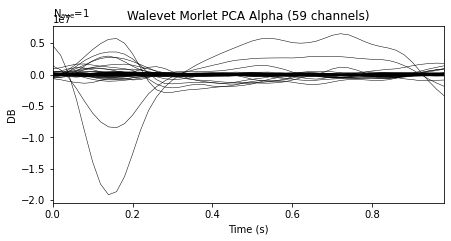

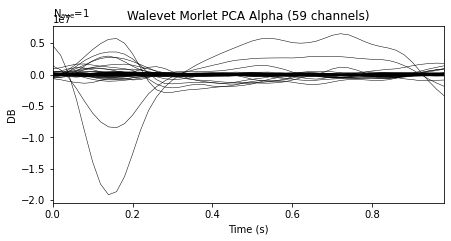

In [ ]:
pca_per = UnsupervisedSpatialFilter(PCA(components), average=False)
pca_data_per = pca_per.fit_transform(Xp)

pca_lineal_per = pca_per.get_params().get('estimator')
percent_pc = pca_lineal_per.explained_variance_ratio_
percent_pc=percent_pc*100
percent_pc=(np.round(percent_pc*100))/100
print('Total Explained variance for linear PC:',sum(percent_pc),'%')
print('Explained variance (see: net.variance)\n')
for i in range(components):
  print('linear PC ',i+1,': ',percent_pc[i],'%')
ev = mne.EvokedArray(np.mean(pca_data_per, axis=0),
                     mne.create_info(components, sfreq,
                                     ch_types='eeg'), tmin=0)
ev.plot(show=False, window_title="PCA", titles=dict(eeg=('Walevet Morlet PCA '+ 'Alpha')),units=dict(eeg='DB'),
        scalings=dict(eeg=1),time_unit='s', spatial_colors=True)

Total Explained variance for linear PC: 99.74999999999999 %
Explained variance (see: net.variance)

linear PC  1 :  43.34 %
linear PC  2 :  8.75 %
linear PC  3 :  5.99 %
linear PC  4 :  5.02 %
linear PC  5 :  4.08 %
linear PC  6 :  3.61 %
linear PC  7 :  3.26 %
linear PC  8 :  3.1 %
linear PC  9 :  2.3 %
linear PC  10 :  1.98 %
linear PC  11 :  1.61 %
linear PC  12 :  1.34 %
linear PC  13 :  1.16 %
linear PC  14 :  1.07 %
linear PC  15 :  1.0 %
linear PC  16 :  0.78 %
linear PC  17 :  0.77 %
linear PC  18 :  0.67 %
linear PC  19 :  0.64 %
linear PC  20 :  0.56 %
linear PC  21 :  0.54 %
linear PC  22 :  0.52 %
linear PC  23 :  0.47 %
linear PC  24 :  0.41 %
linear PC  25 :  0.41 %
linear PC  26 :  0.4 %
linear PC  27 :  0.37 %
linear PC  28 :  0.33 %
linear PC  29 :  0.32 %
linear PC  30 :  0.31 %
linear PC  31 :  0.3 %
linear PC  32 :  0.27 %
linear PC  33 :  0.26 %
linear PC  34 :  0.24 %
linear PC  35 :  0.23 %
linear PC  36 :  0.22 %
linear PC  37 :  0.22 %
linear PC  38 :  0.21 %
l

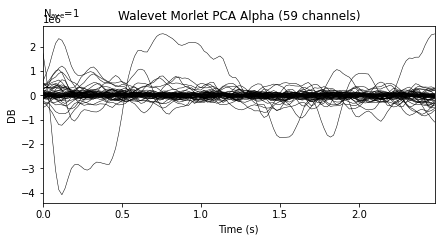

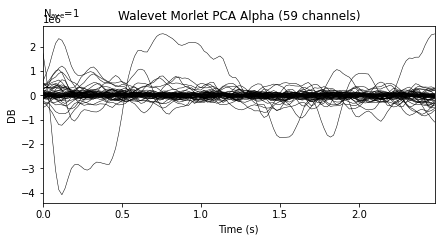

In [ ]:
pca_img = UnsupervisedSpatialFilter(PCA(components), average=False)
pca_data_img = pca_img.fit_transform(Xi)

pca_lineal_img = pca_img.get_params().get('estimator')
percent_pc = pca_lineal_img.explained_variance_ratio_
percent_pc=percent_pc*100
percent_pc=(np.round(percent_pc*100))/100
print('Total Explained variance for linear PC:',sum(percent_pc),'%')
print('Explained variance (see: net.variance)\n')
for i in range(components):
  print('linear PC ',i+1,': ',percent_pc[i],'%')
ev = mne.EvokedArray(np.mean(pca_data_img, axis=0),
                     mne.create_info(components, sfreq,
                                     ch_types='eeg'), tmin=0)
ev.plot(show=False, window_title="PCA", titles=dict(eeg=('Walevet Morlet PCA '+ 'Alpha')),units=dict(eeg='DB'),
        scalings=dict(eeg=1),time_unit='s', spatial_colors=True)

In [ ]:
loadings_per = np.sum(np.multiply((pca_lineal_per.components_**2).T,pca_lineal_per.explained_variance_ratio_), axis=1)*100
loadings_channels_per = dict(zip(channels,loadings_per))
loadings_channels_sort_per = np.array(sorted(loadings_channels_per.items(), key=operator.itemgetter(1), reverse=True))

loadings_img = np.sum(np.multiply((pca_lineal_img.components_**2).T,pca_lineal_img.explained_variance_ratio_), axis=1)*100
loadings_channels_img = dict(zip(channels,loadings_img))
loadings_channels_sort_img = np.array(sorted(loadings_channels_img.items(), key=operator.itemgetter(1), reverse=True))

In [ ]:
n_channels = 30

select_channels_per = loadings_channels_sort_per[:n_channels,0]
weights_channels_per = np.sum((loadings_channels_sort_per[:n_channels,1]).astype(np.float))
print('Los ' +str(n_channels)+ ' Canales que aportan '+'{0:.2f}'.format(weights_channels_per)+'% a la varianza de la señal de percepción:')
print(select_channels_per)

select_channels_img = loadings_channels_sort_img[:n_channels,0]
weights_channels_img = np.sum((loadings_channels_sort_img[:n_channels,1]).astype(np.float))
print('Los ' +str(n_channels)+ ' Canales que aportan '+'{0:.2f}'.format(weights_channels_img)+'% a la varianza de la señal de imaginación:')
print(select_channels_img)

common_channels = [canal for canal in select_channels_img.tolist() if canal in select_channels_per.tolist() ]
if len(common_channels) > 0:
  print('Los '+str(len(common_channels))+' canales comunes para ambas tareas son')
  print(common_channels)

Los 30 Canales que aportan 51.13% a la varianza de la señal de percepción:
['Pz' 'POz' 'P8' 'P1' 'P2' 'P5' 'P4' 'O2' 'PO4' 'PO7' 'CP4' 'PO8' 'P6'
 'CP6' 'O1' 'CP5' 'P3' 'P7' 'PO3' 'CPz' 'C4' 'Fp2' 'CP1' 'AF8' 'CP2' 'CP3'
 'TP7' 'TP8' 'C1' 'Oz']
Los 30 Canales que aportan 53.35% a la varianza de la señal de imaginación:
['PO4' 'POz' 'P2' 'P4' 'Pz' 'PO8' 'O2' 'P6' 'P1' 'CP2' 'P3' 'Oz' 'PO3'
 'P8' 'O1' 'P5' 'PO7' 'CP4' 'CPz' 'CP6' 'CP5' 'CP3' 'P7' 'CP1' 'C2' 'TP7'
 'C5' 'T7' 'FT10' 'FC5']
Los 25 canales comunes para ambas tareas son
['PO4', 'POz', 'P2', 'P4', 'Pz', 'PO8', 'O2', 'P6', 'P1', 'CP2', 'P3', 'Oz', 'PO3', 'P8', 'O1', 'P5', 'PO7', 'CP4', 'CPz', 'CP6', 'CP5', 'CP3', 'P7', 'CP1', 'TP7']


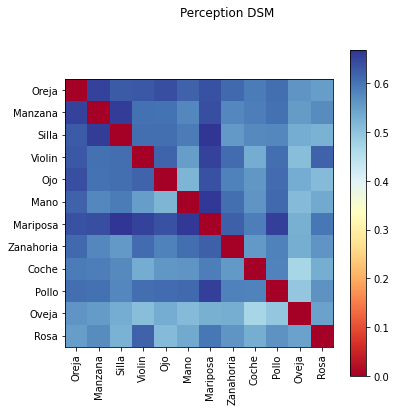

In [ ]:
#RDM of Perception
dsm_per = mne_rsa.dsm_array(X=Xp,y=yp,n_folds=10)
dsm_per = list(dsm_per)[0]
# Plot the DSM
fig = mne_rsa.plot_dsms(dsm_per, cmap='RdYlBu', title='Perception DSM')
ax = fig.axes[0]
ax.set_xticks(np.arange(len(classes_names)))
ax.set_yticks(np.arange(len(classes_names)))
ax.set_xticklabels(classes_names, rotation=90)
ax.set_yticklabels(classes_names)
fig.add_axes(ax)
fig.set_size_inches(6, 6)  # Make figure a little bigger to show axis properly

1.0538366863531334


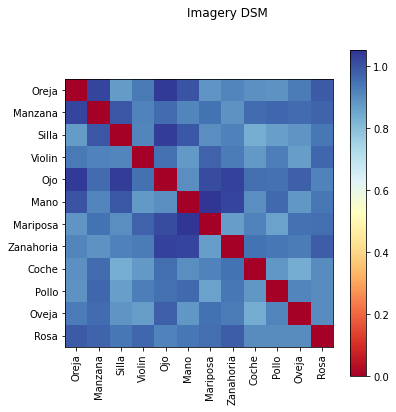

In [ ]:
#RDM of Imagery
dsm_img = mne_rsa.dsm_array(X=Xi,y=yi,n_folds=10)
dsm_img = list(dsm_img)[0]
print(dsm_img.max())
# Plot the DSM
fig = mne_rsa.plot_dsms(dsm_img, cmap='RdYlBu', title='Imagery DSM')
ax = fig.axes[0]
ax.set_xticks(np.arange(len(classes_names)))
ax.set_yticks(np.arange(len(classes_names)))
ax.set_xticklabels(classes_names, rotation=90)
ax.set_yticklabels(classes_names)
fig.add_axes(ax)
fig.set_size_inches(6, 6)  # Make figure a little bigger to show axis properly

RSA score spearman: 0.3006158021083395
RSA score pearson: 0.37244228682199276
RSA score kendall-tau-a: 0.21958041958041957
RSA score regression: 0.3307564341139689


<BarContainer object of 4 artists>

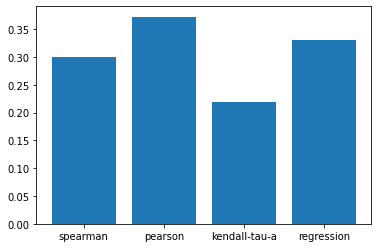

In [ ]:
metric_rsa = ['spearman','pearson','kendall-tau-a','regression']
rsa = []
for m in metric_rsa:
  rsa_result = mne_rsa.rsa(dsm_per, dsm_img, metric=m)
  print('RSA score ' + m +':', rsa_result)
  rsa.append(rsa_result)

rsa = np.array(rsa)
plt.bar(metric_rsa, rsa, align='center')

In [ ]:
Xp,yp,Xi,yi,vect_per,vect_img = prepare_data(per,img)
porcent_trial = int((porcent/100)*len(Xp)/12) # %25

In [ ]:
scores_per_img=MVPA(1, svc,classes=classes, porcent_trial=porcent_trial, pseudo_trials=pseudo_trials, 
                    Xp=Xp, yp=yp, Xi=Xi, yi=yi,vectorizer_per=vect_per,vectorizer_img=vect_img,fit='per')

Process Train 0:   0%|          | 0/1 [00:00<?, ?it/s]

train 1 ...


Process Train 0: 100%|██████████| 1/1 [04:11<00:00, 251.33s/it]


In [ ]:
vectorize_dms = Vectorizer()
score_per_img = vectorize_dms.fit_transform(scores_per_img)

In [ ]:
dsm_per_img = np.mean(score_per_img, axis=1)

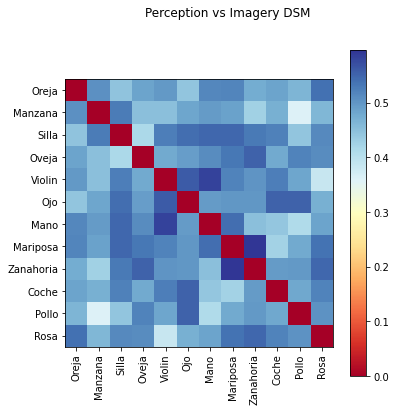

In [ ]:
# Plot the DSM
fig = mne_rsa.plot_dsms(dsm_per_img, cmap='RdYlBu', title='Perception vs Imagery DSM')
ax = fig.axes[0]
ax.set_xticks(np.arange(len(classes_names)))
ax.set_yticks(np.arange(len(classes_names)))
ax.set_xticklabels(classes_names, rotation=90)
ax.set_yticklabels(classes_names)
fig.add_axes(ax)
fig.set_size_inches(6, 6)  # Make figure a little bigger to show axis properly

In [ ]:
list(dsm)[0]

In [ ]:
#RSAof perception vs Imagery
dsm_img = mne_rsa.dsm_array(X=Xi,y=yi)
dsm_img = list(dsm_img)[0]
# Plot the DSM
fig = mne_rsa.plot_dsms(dsm_img, cmap='RdYlBu', title='Perception DSM')
ax = fig.axes[0]
ax.set_xticks(np.arange(len(classes_names)))
ax.set_yticks(np.arange(len(classes_names)))
ax.set_xticklabels(classes_names, rotation=90)
ax.set_yticklabels(classes_names)
fig.add_axes(ax)
fig.set_size_inches(6, 6)  # Make figure a little bigger to show axis properly